In [1]:
import torch
import sys
sys.path.insert(0, "../..")
from src.data import data_tools , make_dataset
from pathlib import Path

Let's revisit the flowers dataset from the first lesson

In [2]:
from src.data.data_tools import DatasetFactoryProvider, DatasetType

flowersfactory = DatasetFactoryProvider.get_factory(DatasetType.FLOWERS)
streamers = flowersfactory.create_datastreamer(batchsize=32)

2023-05-30 11:22:38.199 | INFO     | src.data.data_tools:download_data:81 - Dataset already exists at /workspaces/ML22/data/raw/flower_photos


In [3]:
streamers

{'trainstreamer': ImgDataset (imgsize (224, 224), #classes 5) (streamerlen 91),
 'validstreamer': ImgDataset (imgsize (224, 224), #classes 5) (streamerlen 22)}

In [8]:
trainstreamer = streamers["trainstreamer"].stream()
validstreamers = streamers["validstreamer"].stream()

The FlowersDatasetFactory adds a transform function that will (at random) flip, scale, affine an image. For the model, this is a new image, so it needs to focus on the general patterns instead of pixels.

In [9]:
X, y = next(trainstreamer)
X.shape, y.shape


/home/vscode/.cache/pypoetry/virtualenvs/deep-learning-jHmOY0S3-py3.9/lib/python3.9/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


(torch.Size([32, 3, 224, 224]), torch.Size([32]))

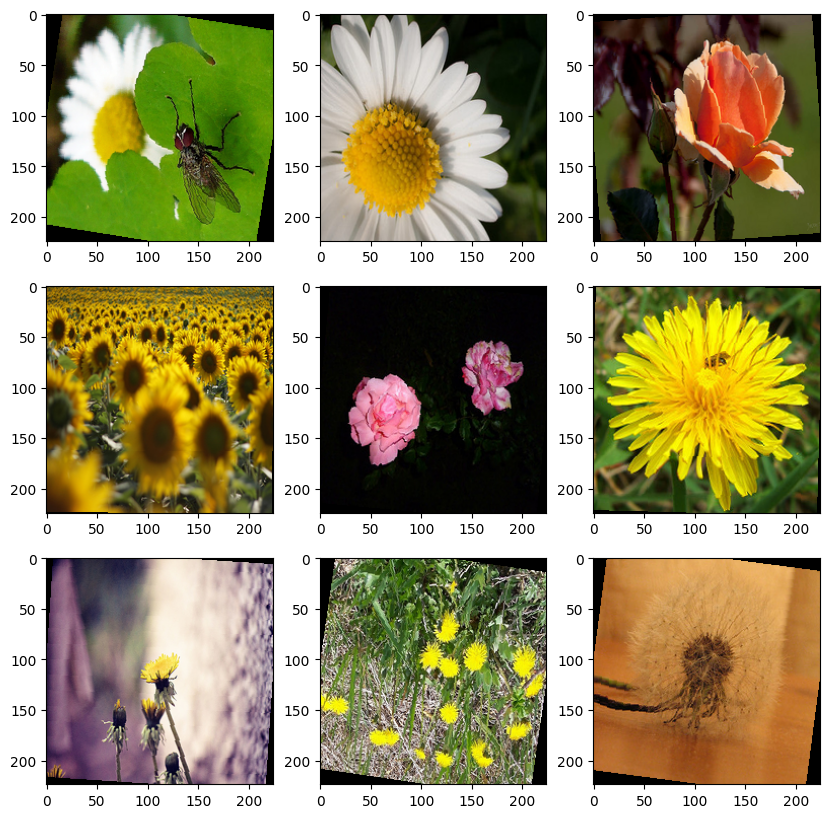

In [10]:
import matplotlib.pyplot as plt
img = X.permute(0, 2, 3, 1)
fig, axs = plt.subplots(3, 3, figsize=(10,10))
axs = axs.ravel()
for i in range(9):
    axs[i].imshow(img[i])

Let's check the ranges, mean and std of a batch

In [11]:
X.max(), X.min(), X.mean(), X.std()


(tensor(1.), tensor(0.), tensor(0.3657), tensor(0.3053))

Instead of building our own resnet, we will just download a pretrained version. This saves us many hours of training.

In [207]:
from torchvision.models import resnet18, ResNet18_Weights
resnet = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)


In [208]:
ResNet18_Weights.DEFAULT

ResNet18_Weights.IMAGENET1K_V1

In [211]:
yhat = resnet(X)
yhat.shape


torch.Size([32, 1000])

However, the resnet is trained for 1000 classes. We have just 5...

We will swap the last layer and retrain the model.

First, we freeze all pretrained layers:

In [212]:
for name, param in resnet.named_parameters():
    param.requires_grad = False


If you study the resnet implementation on [github](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L206) you can see that the last layer is named `.fc`, like this:

```
 self.fc = nn.Linear(512 * block.expansion, num_classes)
 ```

This is a Linear layer, mapping from 512 * block.expansion to num_classes.


so we will swap that for our own. To do so we need to figure out how many features go into the .fc layer.
We can retrieve the incoming amount of features for the current `.fc` with `.in_features`

In [213]:
print(type(resnet.fc))
in_features = resnet.fc.in_features
in_features

<class 'torch.nn.modules.linear.Linear'>


512

Let's swap that layer with a small, two layer, neural network

In [214]:
import torch.nn as nn

resnet.fc = nn.Sequential(
    nn.Linear(in_features, 5)
    # nn.Linear(in_features, 128), nn.ReLU(), nn.Dropout(0.1), nn.Linear(128, 5)
)


In [215]:
yhat = resnet(X)
yhat.shape


torch.Size([32, 5])

So, we have a fully trained resnet, but we added two layers at the end that transforms everything into 5 classes.
These layers are random, so we need to train them for some epochs

In [216]:
from src.models import metrics
accuracy = metrics.Accuracy()

This will take some time to train (about 4 min per epoch), you could scale down to amount of trainsteps to speed things up.

You will start with a fairly high learning rate (0.01), and if the learning stops, after patience epochs the learning rate gets halved.

In [217]:
len(traindataset) // 32, len(validdataset) // 32

(91, 22)

In [ ]:
from src.settings import TrainerSettings, ReportTypes

settings = TrainerSettings(
    epochs=10,
    metrics=[accuracy],
    logdir="modellog",
    train_steps=91,
    valid_steps=15,
    tunewrite=[ReportTypes.TENSORBOARD],
)

trainer = train_model.Trainer(
    model=resnet, 
    settings=settings, 
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam, 
    traindataloader=trainstreamer, 
    validdataloader=validstreamer, 
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
    )

In [ ]:
from src.models import train_model

resnet, loss = train_model.trainloop(
    epochs=10,
    model=resnet,
    metrics=[accuracy],
    optimizer=torch.optim.Adam,
    learning_rate=0.001,
    loss_fn=nn.CrossEntropyLoss(),
    train_dataloader=trainstreamer,
    test_dataloader=validstreamer,
    log_dir="modellog",
    tunewriter=["tensorboard"],
    train_steps=91,
    eval_steps=15,
    patience=2,
    factor=0.1,
    early_stopping_save=False,
)
